# Nathalie MAVEL
Parcours DataScientist -- projet 7 : Implementing a scoring_model  
Notebook 02/02 : modelisations


- libraries 
- Read data


[1.Preprocessing](#section1)

- Imput missing values,
- Transform Booleans into integrals,
- Center-reduce the dataset,
- Divide the dataset into test trains,
- Balancing the data.

[2. Modelisations](#section2)
For each model, there is a hyperparameter optimization with cross validation, probability predictions, a threshold that allows to classify in a binary way the predictions.
- Logistic regression,
- Random Forest Classifier,
- LGB.


**Librairies**

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
# import seaborn as sns

In [2]:
# use of google drive and collab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
PATH_GENERAL = '/content/gdrive/MyDrive/OPC/P7_Implementing_a_scoring_model'

In [4]:
PATH_DATAS = PATH_GENERAL + '/DATAS'

In [5]:
# Ressampling
import imblearn
from imblearn.under_sampling  import RandomUnderSampler
from collections import Counter

In [6]:
# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer

In [7]:
# transformations & metrics
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, fbeta_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

**Read data**

In [8]:
app_test_domain = pd.read_csv(PATH_GENERAL + '/DATAS/app_test_clean.csv')
app_train_domain = pd.read_csv(PATH_GENERAL + '/DATAS/app_train_clean.csv')

In [9]:
app_train_domain.shape

(307511, 281)

indexing via id SK_ID_CURR

In [10]:
app_train_domain.index = app_train_domain.SK_ID_CURR
app_train_domain = app_train_domain.drop(['SK_ID_CURR'], axis=1)

In [11]:
app_test_domain.index = app_test_domain.SK_ID_CURR
app_test_domain = app_test_domain.drop(['SK_ID_CURR'], axis=1)

In [12]:
app_train_domain = app_train_domain.drop(["TARGET_x"], axis=1)
app_train_domain.rename(columns={'TARGET_y':'TARGET'}, inplace=True)

In [13]:
app_train_domain["TARGET"].head()

SK_ID_CURR
100002    1
100003    0
100004    0
100006    0
100007    0
Name: TARGET, dtype: int64

In [14]:
app_test_domain.shape

(48744, 278)

In [15]:
app_train_domain.shape

(307511, 279)

# 1. Preprocessing

In [16]:
def processing(df_train):
    
    # Drop the target from the training data
    if "TARGET" in df_train:
        train = df_train.drop(columns = ["TARGET"])
    else:
        train = df_train.copy()
        
    # Feature names
    features = list(train.columns)

    # Median imputation des valeurs manquantes (stratégie à expliciter lors de la présentation)
    imputer = SimpleImputer(strategy='median')

    # Scale each feature to -1:1
    scaler = MinMaxScaler(feature_range = (0, 1))

    # Replace the boolean column by numerics values (la colonne que nous avons créées dans le preprocessing)
    train["DAYS_EMPLOYED_ANOM"] = train["DAYS_EMPLOYED_ANOM"].astype("int")

    # Fit on the training data
    imputer.fit(train)

    # Transform both training and testing data
    train = imputer.transform(train)

    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    
    return train

In [30]:
def sampling(df_X, df_y):

    X = df_X.copy()
    y = df_y.copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test

In [31]:
# %%time
print("Preprocessing")
# imputer for handling missing values
from sklearn.impute import SimpleImputer
from collections import Counter
imputer = SimpleImputer(strategy='median')

train = processing(app_train_domain)
X_train, X_test, y_train, y_test = sampling(train, app_train_domain["TARGET"])

print('Original dataset shape %s' % Counter(app_train_domain["TARGET"]))

Preprocessing
Original dataset shape Counter({0: 282686, 1: 24825})


## Rebalance the target on the training set. 

Given the number of data, we will use undersampling (advantages: the calculation time will be shorter and the dataset is very large)

In [ ]:
us = RandomUnderSampler()

In [ ]:
print("Undersampling")
X_us, y_us = us.fit_resample(X_train,  y_train)
print('Resampled dataset shape %s' % Counter(y_us))

Undersampling
Resampled dataset shape Counter({0: 19860, 1: 19860})


Class 0: 226148
Class 1: 19860
Proportion: 11.39 : 1


([<matplotlib.patches.Wedge at 0x7ff520df7ed0>,
 [Text(-0.27599847803582855, -1.0648121149394885, 'Classe 0'),
  Text(0.3010891943873195, 1.1616132303926274, 'Classe 1')],
 [Text(-0.1505446243831792, -0.5808066081488118, '91.9%'),
  Text(0.17563536339260305, 0.6776077177290325, '8.1%')])

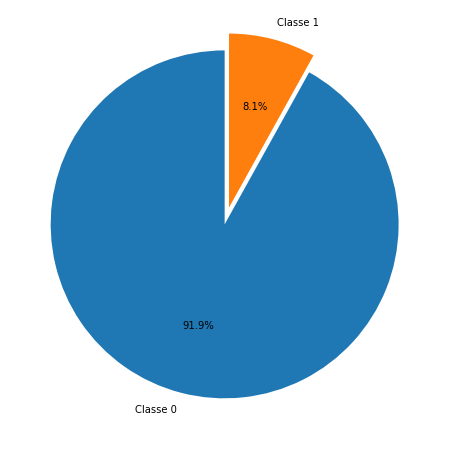

In [ ]:
target_count =  y_train.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=False, startangle=90,)

Class 0: 19860
Class 1: 19860
Proportion: 1.0 : 1


([<matplotlib.patches.Wedge at 0x7ff5212bd4d0>,
 [Text(-1.1, 1.3471114790620887e-16, 'Classe 0'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'Classe 1')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

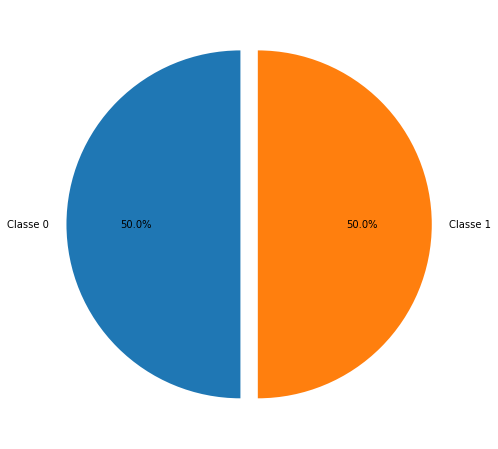

In [ ]:
target_count =  y_us.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1],
        labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=False, startangle=90,)

# 2. Modélisation

Fonctions

In [ ]:
# Customised score cross-validation function that also returns proba of belonging to class 1
# Fonction de cross validation de score personalisée qui renvoie aussi proba d'appartenir à la classe 1

def score_cv_include_proba(clf, x, y, cv=5, beta=2):
    # initialize sc_score and proba
    cv_score = []
    y_pred_proba = []

    # creation de folds pour CV
    kf = StratifiedKFold(n_splits=cv, shuffle = False)
    
    for train_idx, val_idx in kf.split(x, y):
        
        # Entrainement pour le fold considéré
        X_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
        
        # Validation
        X_val, y_val = x.iloc[val_idx], y.iloc[val_idx]

        # Resampling in undersamplaing      
        X_train, y_train = us.fit_resample(X_train, y_train)
        
        # Training
        clf.fit(X_train, y_train)

        # Pprediction in test 
        ypred = clf.predict(X_val)
        
        # Sauvegarde des probas pour la classe 1
        yprob = clf.predict_proba(X_val)
        y_pred_proba+=(list(yprob[:,1]))

        # Enregistrement des scores
        score = round(fbeta_score(y_val, ypred, beta = beta), 3)
        
        cv_score.append(score)
    
    return np.array(cv_score), np.array(y_pred_proba)
    
#  sources : http://cedric.cnam.fr/vertigo/cours/ml2/tpEvaluationSelectionModeles.html

In [ ]:
#  régler le seuil utilisé pour mapper les probabilités aux étiquettes de classe.
#  fonction indiquant le seuil optimal qui maximise le score F2

def threshold_selection(y_proba, y_test):
    
    scores = []
    for threshold in np.linspace(0, 1, num=100):
        y_pred = y_proba > threshold
        score = fbeta_score(y_test, y_pred, beta=2)
        scores.append(score) 

    scores = np.asarray(scores)
    print(scores.argmax()
    )
    best_threshold, best_score = (scores.argmax()*.01, round(scores.max(), 3))
    
    print('Best Threshold :', best_threshold)
    print('Best Score :', best_score)

    plt.plot(np.linspace(0, 1, num=100), scores, lw=1)
    plt.axvline(best_threshold, ls='--', lw=1, c='r')
    plt.xlabel('Threshold')
    plt.ylabel('Score performed')
    plt.show()
    return best_threshold
# https://www.yourdatateacher.com/2021/06/14/are-you-still-using-0-5-as-a-threshold/ 

In [ ]:
def transform_treshold(df, tresh):
    new_df = (df >= tresh).astype("int")
    return new_df

Initialization dataframe with results y_true  
y_true ==0 ==> repays  
y_true ==1 ==> NO Repays  

In [ ]:
# Initialization dataframe with results y_true
df_results = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

In [ ]:
df_results.head()

,y_true
SK_ID_CURR,
396899,0
322041,0
220127,0
251531,0
345558,0


## 2.1 Logistic Regression

In [ ]:
log_reg = LogisticRegression(class_weight='balanced') 
ftwo_scorer = make_scorer(fbeta_score, beta=2)
# use a full grid over all parameters
grid_values = {'penalty': ['l1','l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
#run grid search
grid = GridSearchCV(log_reg, param_grid=grid_values, cv=5, scoring = ftwo_scorer)
grid.fit(X_us, y_us)
print("Grid-Search with F2-score")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

Grid-Search with F2-score
Best parameters: {'C': 0.001, 'penalty': 'l2'}
Best cross-validation score (F2-score)): 0.689


In [ ]:
# after identification best hyperparameters
log_reg = LogisticRegression(C=0.001, penalty='l2', class_weight='balanced')
log_reg.fit(X_us, y_us)

y_pred = log_reg.predict(X_test)
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["log_reg_pred"] = log_reg_pred
df_results.head()

,y_true,log_reg_pred
SK_ID_CURR,,
396899,0,0.452282
322041,0,0.411937
220127,0,0.679928
251531,0,0.572054
345558,0,0.556632


51
Best Threshold : 0.51
Best Score : 0.396


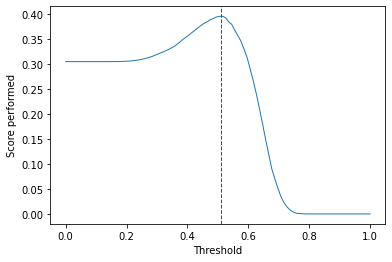

In [ ]:
X_test = pd.DataFrame(X_test)
y_proba = score_cv_include_proba(log_reg, X_test, y_test, cv=5, beta=2)[1]

best_threshold = threshold_selection(y_proba, y_test)

In [ ]:
df_results["y_pred_lr_bin"] = transform_treshold(df_results["log_reg_pred"], best_threshold)
df_results.head()

,y_true,log_reg_pred,y_pred_lr_bin
SK_ID_CURR,,,
396899,0,0.452282,0
322041,0,0.411937,0
220127,0,0.679928,1
251531,0,0.572054,1
345558,0,0.556632,1


In [ ]:
y_pred_proba = log_reg.predict_proba(X_test)
print((roc_auc_score(y_test, y_pred_proba[:,1])).round(3))

0.733


## 2.2 Random forest

In [ ]:
# # Recherche sur grille des meilleurs paramètres du modèle

# clf_rf = RandomForestClassifier(random_state=2, class_weight='balanced')

# param_grid = {'n_estimators' : [50, 100, 150], 
#               'max_depth': [3, 5, None],
#               'max_features': [1, 3, 10],
#               'min_samples_split': [2, 3, 10],
#               'min_samples_leaf' : [1, 16, 64]}

# ftwo_scorer = make_scorer(fbeta_score, beta=2)

# grid = RandomizedSearchCV(clf_rf, param_grid, n_iter=50, cv=5, scoring=ftwo_scorer, verbose=1)

# grid.fit(X_us, y_us)

# print("Grid-Search with F2-score")
# print("Best parameters:", grid.best_params_)
# print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

51
Best Threshold : 0.51
Best Score : 0.391


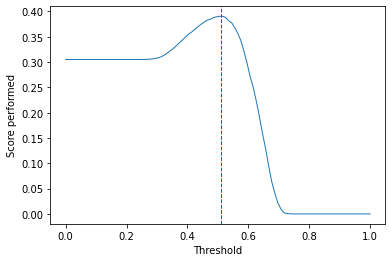

CPU times: user 12.6 s, sys: 202 ms, total: 12.8 s
Wall time: 12.9 s


In [ ]:
%%time

# Make the model with the specified regularization parameter
clf_rf = RandomForestClassifier(class_weight='balanced',
                                min_samples_split=2, 
                                max_depth=5,
                                min_samples_leaf= 1,
                                max_features=3, 
                                random_state=2
                                )

# Train on the training data
clf_rf.fit(X_us, y_us)

# Make predictions
# Make sure to select the second column only
y_pred_proba_rf = []
rf_pred = clf_rf.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["y_pred_rf"] = rf_pred

X_test = pd.DataFrame(X_test)
y_proba = score_cv_include_proba(clf_rf, X_test, y_test, cv=5, beta=2)[1]

# threshold optimisation
best_threshold = threshold_selection(y_proba, y_test)

In [ ]:
df_results["y_pred_rf_bin"] = transform_treshold(df_results["y_pred_rf"], best_threshold)
df_results.head()

,y_true,log_reg_pred,y_pred_lr_bin,y_pred_rf,y_pred_rf_bin
SK_ID_CURR,,,,,
396899,0,0.452282,0,0.489863,0
322041,0,0.411937,0,0.402873,0
220127,0,0.679928,1,0.546610,1
251531,0,0.572054,1,0.549700,1
345558,0,0.556632,1,0.485349,0


In [ ]:
y_pred_proba = clf_rf.predict_proba(X_test)
print((roc_auc_score(y_test, y_pred_proba[:,1])).round(3))

0.739


## LGB

In [ ]:
# # %%time
# # Recherche sur grille des meilleurs paramètres du modèle

# lgbc = lgb.LGBMClassifier(random_state=2, class_weight='balanced', objective='binary')

# param_grid = {'boosting' : ['gbdt', 'dart', 'goss'],
#              'n_estimators': [250, 500, 750, 1000], 
#              'learning_rate' : [0.005, 0.01, 0.1],
#              'max_depth' : [5, 10, 20, None],
#              'num_leaves' : [4, 16, 64, 128],
#              'min_data_in_leaf' : [100, 500], 
#              'reg_alpha' : [0.8, 1, 1.2, 1.4],
#              'reg_lambda' : [1, 1.2, 1.4, 1.6]}

# ftwo_scorer = make_scorer(fbeta_score, beta=2)

# grid = RandomizedSearchCV(lgbc, param_grid, n_iter=50, cv=5, scoring=ftwo_scorer, verbose=1)

# grid.fit(X_us, y_us)

# print("Grid-Search with F2-score")
# print("Best parameters:", grid.best_params_)
# print("Best cross-validation score (F2-score)): {:.3f}".format(grid.best_score_))

In [ ]:
%%time

# Create the model
# clf_lgb = lgb.LGBMClassifier(n_estimators=750,
#                              objective='binary',
#                              class_weight='balanced',
#                              learning_rate=0.05,
#                              reg_alpha=0.1,
#                              reg_lambda=0.1,
#                              subsample=0.8,
#                              n_jobs=-1,
#                              random_state=0
#                             )
clf_lgb = lgb.LGBMClassifier(n_estimators=1000,
                             objective='binary',
                             class_weight='balanced',
                             learning_rate=0.1,
                             reg_alpha=1,
                             reg_lambda=1.2,
                             num_leaves=128, 
                             subsample=0.8,
                             min_data_in_leaf=100,
                             max_depth=5, 
                             boosting='dart',
                             n_jobs=-1,
                             random_state=0
                            )
# Train on the training data
clf_lgb.fit(X_us, y_us)

# Make predictions
# Make sure to select the second column only
lgb_pred = clf_lgb.predict_proba(X_test)[:, 1]

# Submission dataframe
df_results["y_pred_lgb"] = lgb_pred

CPU times: user 3min 34s, sys: 465 ms, total: 3min 35s
Wall time: 1min 51s


50
Best Threshold : 0.5
Best Score : 0.405


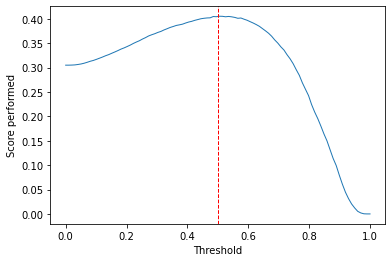

In [ ]:
X_test = pd.DataFrame(X_test)
y_proba = score_cv_include_proba(clf_lgb, X_test, y_test, cv=5, beta=2)[1]

# Threshold optimisation
best_threshold = threshold_selection(y_proba, y_test)

In [ ]:
df_results["y_pred_lgb_bin"] = transform_treshold(df_results["y_pred_lgb"], best_threshold.round(2))

In [ ]:
df_results.head(20)

,y_true,log_reg_pred,y_pred_lr_bin,y_pred_rf,y_pred_rf_bin,y_pred_lgb,y_pred_lgb_bin
SK_ID_CURR,,,,,,,
396899,0,0.452282,0,0.489863,0,0.462470,0
322041,0,0.411937,0,0.402873,0,0.378218,0
220127,0,0.679928,1,0.546610,1,0.731581,1
251531,0,0.572054,1,0.549700,1,0.476030,0
345558,0,0.556632,1,0.485349,0,0.509833,1
251419,0,0.629254,1,0.582226,1,0.610602,1
433604,0,0.199370,0,0.358659,0,0.116595,0
268026,0,0.111167,0,0.288274,0,0.106470,0
218614,0,0.766401,1,0.665674,1,0.804416,1


In [ ]:
y_pred_proba = clf_lgb.predict_proba(X_test)
print((roc_auc_score(y_test, y_pred_proba[:,1])).round(3))

0.838


# 3. Evaluation 

- Confusion matrix

In [ ]:
df_evaluation = df_results.copy()

In [ ]:
df_evaluation = df_evaluation.drop(['log_reg_pred', 'y_pred_rf', 'y_pred_lgb' ], axis=1)

In [ ]:
df_evaluation.shape

(61503, 4)

In [ ]:
def plot_confusion_matrix(df_true, df_pred):
  # Get the confusion matrix
  # https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea 

  cf_matrix = confusion_matrix(df_true, df_pred)
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  plt.xlabel('y_Predict')
  plt.ylabel('y_True')
  plt.show()
 

In [ ]:
def plot_confusion_matrix(df_true, df_pred):
  # Get the confusion matrix
  # https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea 

  cf_matrix = confusion_matrix(df_true, df_pred)
  # group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  # group_counts = ["{0:0.0f}".format(value) for value in
  #                 cf_matrix.flatten()]
  # group_percentages = ["{0:.2%}".format(value) for value in
  #                     cf_matrix.flatten()/np.sum(cf_matrix)]
  # labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
  #           zip(group_names,group_counts,group_percentages)]
  # labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
  plt.xlabel('y_Predict')
  plt.ylabel('y_True')
  plt.show()

In [ ]:
import seaborn as sns

In [ ]:
df_evaluation.head()

,y_true,y_pred_lr_bin,y_pred_rf_bin,y_pred_lgb_bin
SK_ID_CURR,,,,
396899,0,0,0,0
322041,0,0,0,0
220127,0,1,1,1
251531,0,1,1,0
345558,0,1,0,1


In [ ]:
cf_matrix = confusion_matrix(df_evaluation['y_true'], df_evaluation['y_true'])
cf_matrix = confusion_matrix(df_evaluation['y_true'], df_evaluation['y_pred_lr_bin'])
cf_matrix = confusion_matrix(df_evaluation['y_true'], df_evaluation['y_pred_rf_bin'])
cf_matrix = confusion_matrix(df_evaluation['y_true'], df_evaluation['y_pred_lgb_bin'])
print(cf_matrix)

[[39261 17277]
 [ 1458  3507]]


y_true


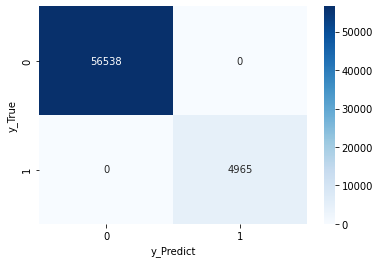

y_pred_lr_bin


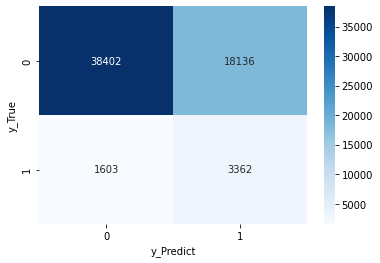

y_pred_rf_bin


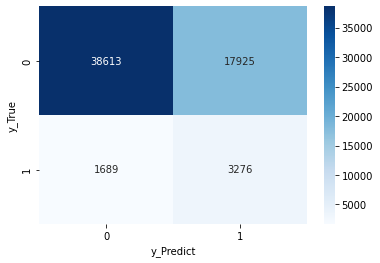

y_pred_lgb_bin


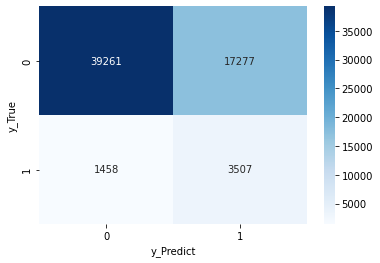

In [ ]:
for i in df_evaluation.columns: 
  print(i)
  plot_confusion_matrix(df_evaluation['y_true'], df_evaluation[i])

## 3.2 Evaluation metrics
https://towardsdatascience.com/is-f1-the-appropriate-criterion-to-use-what-about-f2-f3-f-beta-4bd8ef17e285

- precision: coeff determines that when the classifier declares a prediction to be 1, it is X% correct
- recall: coeff determines the percentage of 1's detected by the classifier

F1 score, average of precision and recall, it gives more weight to low values

In [ ]:
df_results.head().round(2)

,y_true,log_reg_pred,y_pred_lr_bin,y_pred_rf,y_pred_rf_bin,y_pred_lgb,y_pred_lgb_bin
SK_ID_CURR,,,,,,,
396899,0,0.44,0,0.48,0,0.40,0
322041,0,0.39,0,0.39,0,0.42,0
220127,0,0.69,1,0.55,1,0.73,1
251531,0,0.57,1,0.58,1,0.48,1
345558,0,0.56,1,0.48,0,0.51,1


In [ ]:
def result_metrics(i, j):
  df_m = pd.DataFrame()
  df_m.loc[i, 'accuracy'] = round(accuracy_score(df_evaluation["y_true"], df_evaluation[j],), 3)
  df_m.loc[i, 'precision'] = round(precision_score(df_evaluation["y_true"], df_evaluation[j]), 3)
  df_m.loc[i, 'recall'] = round(recall_score(df_evaluation["y_true"], df_evaluation[j]), 3)
  df_m.loc[i, 'f1_score'] = round(f1_score(df_evaluation["y_true"], df_evaluation[j]), 3)
  df_m.loc[i, 'f2_score'] = round(fbeta_score(df_evaluation["y_true"], df_evaluation[j], beta=2), 3)
  df_m.loc[i, 'f3_score'] = round(fbeta_score(df_evaluation["y_true"], df_evaluation[j], beta=3), 3)
  return df_m

In [ ]:
df1 = result_metrics('LR', 'y_pred_lr_bin')
df2 = result_metrics('RF', 'y_pred_rf_bin')
df3 = result_metrics('LGBM', 'y_pred_lgb_bin')
frames = [df1, df2, df3]
df_result_metric = pd.concat(frames)

In [ ]:
df_result_metric

,accuracy,precision,recall,f1_score,f2_score,f3_score
LR,0.663,0.153,0.698,0.250,0.407,0.514
RF,0.657,0.148,0.685,0.244,0.397,0.503
LGBM,0.660,0.158,0.738,0.260,0.425,0.539


précision et recall évolue de la même façon, une precision + faible que le recall ==> les scores F sont donc tous orientées de la même façon.

In [ ]:
# https://stats.stackexchange.com/questions/415463/precision-recall-against-threshold-curve-not-useful-in-improving-model-performan

In [ ]:
false_pos_lgb, true_pos_lgb, treshold_lgb = roc_curve(y_test, lgb_pred)
false_pos_lr, true_pos_lr, treshold_lr = roc_curve(y_test, log_reg_pred)
false_pos_rf, true_pos_rf, treshold_rf = roc_curve(y_test, rf_pred)

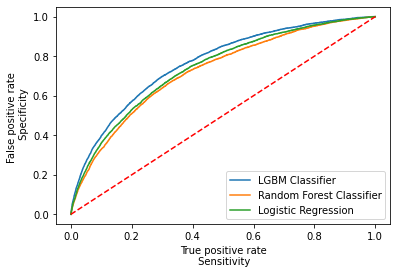

In [ ]:
plt.plot(false_pos_lgb, true_pos_lgb, label="LGBM Classifier")
plt.plot(false_pos_rf, true_pos_rf, label="Random Forest Classifier")
plt.plot(false_pos_lr, true_pos_lr, label="Logistic Regression")
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel("False positive rate \n Specificity")
plt.xlabel("True positive rate\n Sensitivity")
plt.legend()

# 4. Save mode

In [ ]:
import sklearn
import joblib
import pickle

with open('/content/gdrive/MyDrive/OPC/P7_Implementing_a_scoring_model/model_lgb.pickle', 'wb') as file :
    pickle.dump(clf_lgb, file)

# 4. interprétabilité globale

In [19]:
pip install shap==0.39

     |████████████████████████████████| 356 kB 4.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491683 sha256=92721ad0d524be8921fd6aac8c30fa48c1508fa23946897c75261a50a435d349
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
# Import du module SHAP, initialisation et import du modèle
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import matplotlib
shap.initjs()

- Display shap with respect to the global model
- Display shap with respect to individuals and with respect to an important variable

In [20]:
# Import du module SHAP, initialisation et import du modèle
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()

with open('/content/gdrive/MyDrive/OPC/P7_Implementing_a_scoring_model/model_lgb.pickle', 'rb') as file : 
    LGB = pickle.load(file)

In [21]:
app_train_domain.shape

(307511, 279)

- Display shap with respect to the global model

       
LGBMClassifier(boosting='dart', class_weight='balanced', max_depth=5,
               min_data_in_leaf=100, n_estimators=1000, num_leaves=128,
               objective='binary', random_state=0, reg_alpha=1, reg_lambda=1.2,
               subsample=0.8)
CPU times: user 1.99 s, sys: 17.8 ms, total: 2.01 s
Wall time: 1.73 s


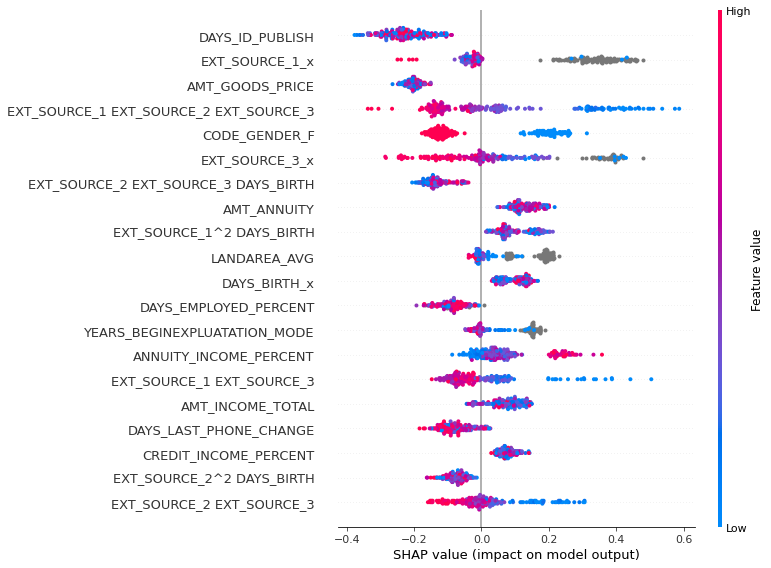

In [36]:
model_name = [LGB]
for m in model_name : 
  print('       ')
  print(m)

  X_test_sample = app_test_domain.head(200)
  explainer = shap.TreeExplainer(m, feature_perturbation="interventional", model_output="raw")
  shap_values = explainer.shap_values(X_test_sample)
  %time shap_values = shap.TreeExplainer(m).shap_values(X_test_sample)
  shap.summary_plot(shap_values[1], X_test_sample)

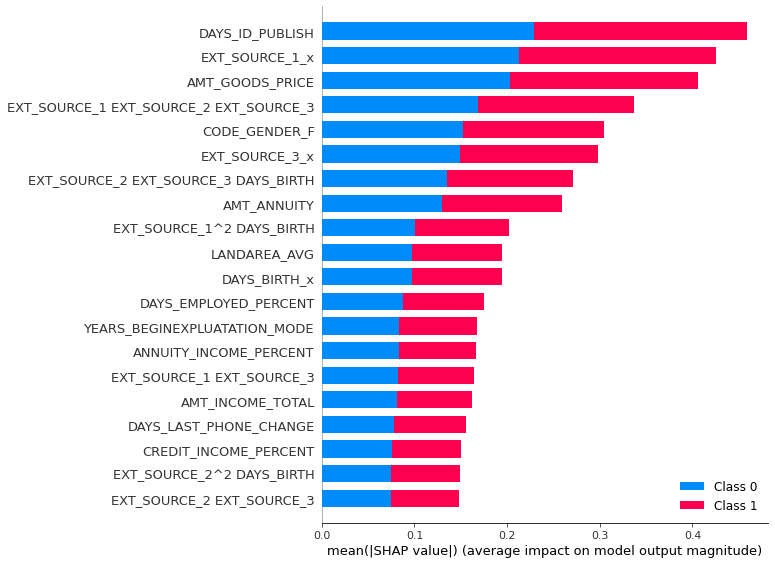

In [37]:
shap.summary_plot(shap_values, X_test_sample)

-Interpretation of the model for individuals

In [41]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][120,:], X_test_sample.iloc[120], contribution_threshold=80)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][12,:], X_test_sample.iloc[12])